### This is the code to implement feature selection methods
#### References: 


#### Packages
- Package Pandas (2.2). (2024). [Python]. https://pandas.pydata.org/
- Droettboom, J. D. H., Michael. (2024). Package matplotlib (3.8.4) [Python]. https://matplotlib.org
- Package scikit-learn (1.4). (2024). [Pyhton]. https://scikit-learn.org/stable/index.html - - Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12(85), 2825–2830.

In [1]:
# Importing packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE


In [2]:
# Importing the original dataset
df_raw = pd.read_csv('../data/cleaned_df.csv')


In [3]:
# Let's drop some columns that are not useful for our analysis, due to causal relationships or to the existence of duplicated information
columns_to_drop = ['ECO_fiscal_result_12months', 'ECO_inflation_12months','ECO_gross_debt_gdp_pre', 'ECO_gross_debt_gdp_pos',
       'ECO_gross_debt_R$_pre', 'ECO_gross_debt_R$_pos', 'ECO_net_debt_gdp_%',
       'ECO_net_debt_R$', 'ECO_net_debt_gdp_%_federal_govt',
       'ECO_net_debt_R$_federal_govt', 'ECO_net_debt_R$_dlspc']

# Dropping columns
df_raw.drop(columns_to_drop, axis=1, inplace=True)

# Rename a column
df_raw.rename(columns={"Euro area (19 countries)":"WD_Euro area (19 countries)"}, inplace=True)

# Setting date as index
df_raw.set_index('Date', inplace=True)
df_raw.to_csv('../data/data_orig_parameters.csv', index=True)

### Feature Selection

In [4]:
# Define test and validation set sizes
# target variable
target_variable = df_raw.columns[0]

# Create X and y
X_train = df_raw.drop(target_variable, axis=1)
y_train = df_raw[target_variable]

# Define the most XX important features
number_of_features = 40

In [5]:
# Define a function to plot the most important features
def plot_selected_features(dataframe, number_of_features, title):

    # Plot a bar chart 
    plt.figure(figsize=(10, 7))
    plt.barh(dataframe.iloc[:,0][:number_of_features], # select the most important features names
            dataframe.iloc[:,1][:number_of_features]) # select the importance values of these features
    
    plt.xlabel(' '.join(title.split(' ')[:2]))
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis() # present the most important feature at the top
    plt.show()

### Random Forest feature selection evaluation

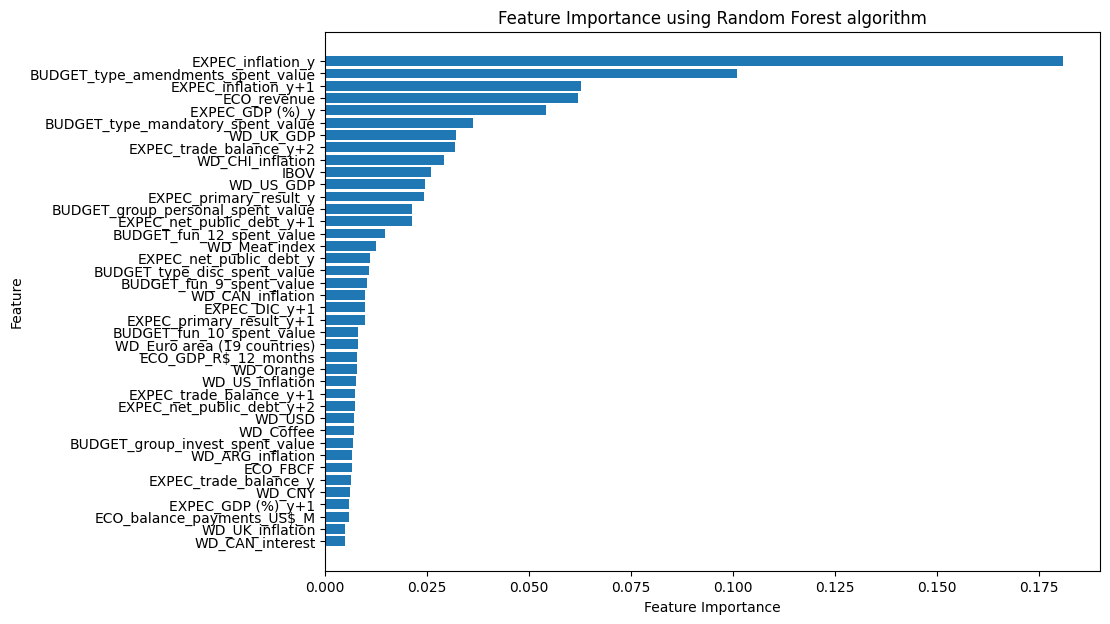

In [6]:
# Train the Random Forest model
model = RandomForestRegressor(n_estimators=1000, random_state=42) # 1000 trees
model.fit(X_train, y_train)

# Obtain feature importance
feature_importances = model.feature_importances_

# Create a DataFrame to visualize feature importance
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the most important features
plot_selected_features(features_df, number_of_features, 'Feature Importance using Random Forest algorithm')

# subset df_raw with the most important features
data_cleaned_RF = df_raw[[target_variable] + features_df.iloc[:,0][:number_of_features].to_list()]

# Export the most important features to a csv file
data_cleaned_RF.to_csv('../data/data_cleaned_RF.csv', index=True)


### Feature Importance using Lasso model

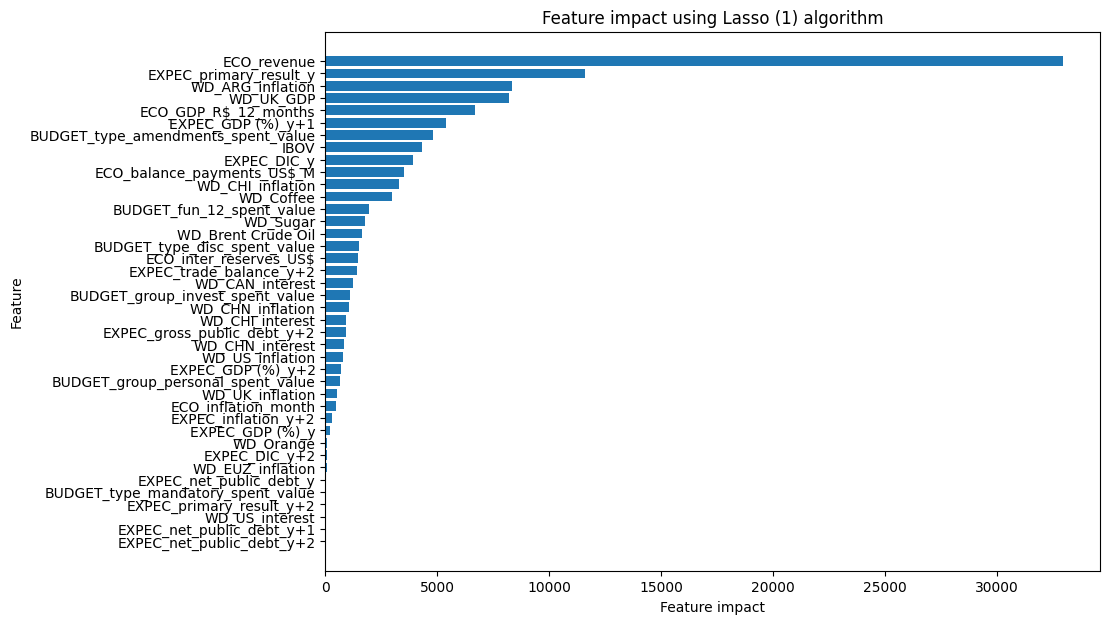

In [8]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define some alphas to test which one is the best
alphas = [10, 100, 150, 165, 175, 185, 190, 195, 200, 202, 210, 215, 230, 250, 300, 500] # Alpha is the regularization parameter

# Initialize the LassoCV model
lasso_cv = LassoCV(alphas=alphas, max_iter = 10000000, cv=10, random_state=42) # 10-fold cross-validation, 10 million iterations
lasso_cv.fit(X_train_scaled, y_train)

# Get the coefficients of the model
features_df = pd.DataFrame(lasso_cv.coef_, X_train.columns, columns=['coefficients'])

# Order the coefficients by absolute value
features_df = features_df.abs().sort_values(by='coefficients', ascending=False)

# Make the index a column and rename it to "features"
features_df.reset_index(inplace=True)
features_df.rename(columns={'index':'Feature'}, inplace=True)

#Plot the most important features
plot_selected_features(features_df, number_of_features, 'Feature impact using Lasso (1) algorithm')

# subset df_raw with the most important features
data_cleaned_LASSO = df_raw[[target_variable] + features_df.iloc[:,0][:number_of_features].to_list()]

# Export the most important features to a csv file
data_cleaned_LASSO.to_csv('../data/data_cleaned_LASSO.csv', index=True)

### Feature Importance using Recursive Feature Elimination - RFE

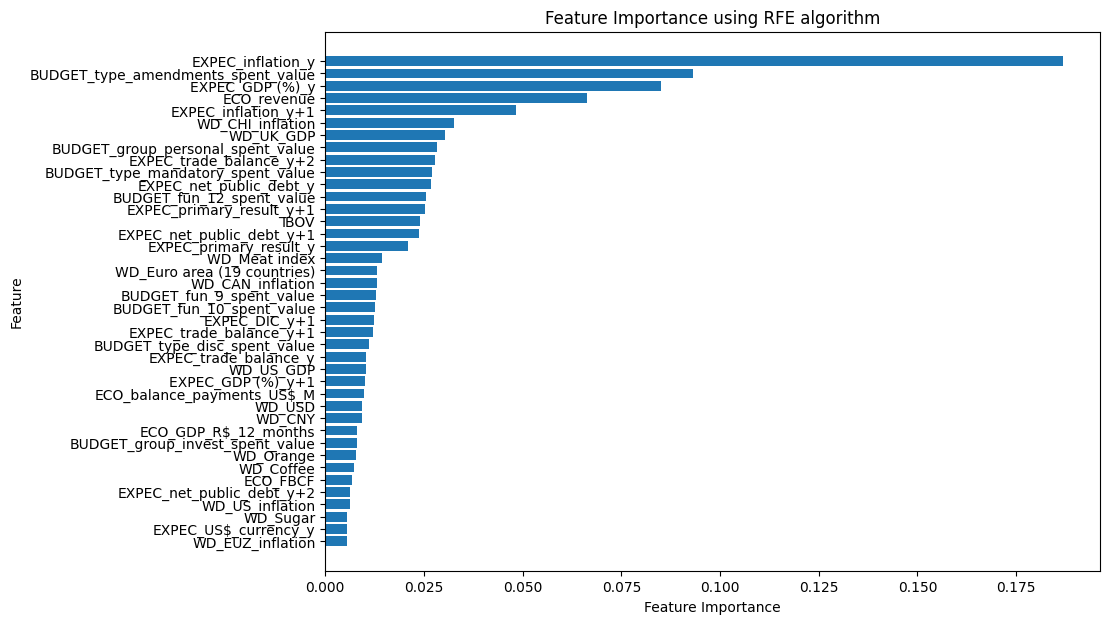

In [10]:
# Initialize the model
modelo = RandomForestRegressor()

# Initialize the RFE model
rfe = RFE(estimator=modelo, n_features_to_select=number_of_features)

# Fit the RFE model
rfe.fit(X_train, y_train)

# Check the most important features
seleced_variables = X_train.columns[rfe.support_]
coefficients = rfe.estimator_.feature_importances_

# Combine both in a dataframe called "features_df"
features_df = pd.DataFrame({'Feature': seleced_variables, 'Importance': coefficients})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot a bar chart 
plot_selected_features(features_df, number_of_features, 'Feature Importance using RFE algorithm')

# subset df_raw with the most important features
data_cleaned_RFE = df_raw[[target_variable] + features_df.iloc[:,0][:number_of_features].to_list()]

# Export the most important features to a csv file
data_cleaned_RFE.to_csv('../data/data_cleaned_RFE.csv', index=True)
